# SNPTEST HOLBAEK Glucagon GWAS

In [1]:
workdir = "/emc/cbmr/users/mjl259/project_glucagon"

In [2]:
pathgeno = "/emc/cbmr/data/imputed/Target/Sanger/hrc/Holbaek3batchmerge.vcfs"

In [3]:
pathpheno = "/emc/cbmr/users/mjl259/project_glucagon/phenotype"

## 1. Prepare phenotype files

### 1.1 Obesity Clinic

In [14]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"
. /home/mjl259/.bashrc

# Remove header
sed 1d $3/SNPTEST_holbaek_obesity_clinic_ped.txt > \
$3/SNPTEST_holbaek_obesity_clinic.tmp1

# Extract the order of individuals from VCF file
bcftools query -l $2/chr22.vcf.gz > \
$3/HOLBAEK_IDs_from_vcf.txt

# Sort phenotype file according to vcf order
awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
$3/SNPTEST_holbaek_obesity_clinic.tmp1 \
$3/HOLBAEK_IDs_from_vcf.txt > \
$3/SNPTEST_holbaek_obesity_clinic.tmp2

# Specify variable types
sed '1 s/^/0 0 0 D P P\n/' \
$3/SNPTEST_holbaek_obesity_clinic.tmp2 > \
$3/SNPTEST_holbaek_obesity_clinic.tmp3

# Add header
{ echo "ID_1 ID_2 missing sex glucagon_inv_norm_asb glucagon_inv_norm_asbb"; \
cat $3/SNPTEST_holbaek_obesity_clinic.tmp3; } > \
$3/SNPTEST_HOLBAEK_obesity_clinic_glucagon.sample

# remove intermediate files
rm $3/*.tmp*

### 1.2 Population-based

In [15]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"
. /home/mjl259/.bashrc

# Remove header
sed 1d $3/SNPTEST_holbaek_population_ped.txt > \
$3/SNPTEST_holbaek_population.tmp1

# Extract the order of individuals from VCF file
bcftools query -l $2/chr22.vcf.gz > \
$3/HOLBAEK_IDs_from_vcf.txt

# Sort phenotype file according to vcf order
awk 'FNR==NR {x2[$1] = $0; next} $1 in x2 {print x2[$1]}' \
$3/SNPTEST_holbaek_population.tmp1 \
$3/HOLBAEK_IDs_from_vcf.txt > \
$3/SNPTEST_holbaek_population.tmp2

# Specify variable types
sed '1 s/^/0 0 0 D P P\n/' \
$3/SNPTEST_holbaek_population.tmp2 > \
$3/SNPTEST_holbaek_population.tmp3

# Add header
{ echo "ID_1 ID_2 missing sex glucagon_inv_norm_asb glucagon_inv_norm_asbb"; \
cat $3/SNPTEST_holbaek_population.tmp3; } > \
$3/SNPTEST_HOLBAEK_population_glucagon.sample

# remove intermediate files
rm $3/*.tmp*

## 2. SNPTEST

In [22]:
%%writefile $workdir/scripts/SNPTEST_glucagon_HOLBAEK.sh
#!/bin/bash
#$ -S /bin/bash
#$ -cwd
#$ -pe smp 1
#$ -N SNPTEST

chr=${c}
group=${g}
pheno=${p}
pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

/oldhome/tdr438/snptest_v2.5.2/snptest_v2.5.2 -data ${pathgeno}/chr${chr}.vcf.gz ${pathpheno}/SNPTEST_HOLBAEK_${group}_glucagon.sample \
    -o ${workdir}/SNPTEST_results/SNPTEST_HOLBAEK_${group}_chr${chr}_${pheno}.out \
    -frequentist 1 \
    -method expected \
    -pheno ${pheno} \
    -hwe

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/SNPTEST_glucagon_HOLBAEK.sh


In [23]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/SNPTEST_glucagon_HOLBAEK.sh"
declare -a groups=("obesity_clinic" "population")
declare -a phenos=("glucagon_inv_norm_asb" "glucagon_inv_norm_asbb")
for chr in {1..22}; do # loop through each chr
for group in "${groups[@]}"; do # loop through each group
for pheno in "${phenos[@]}"; do # loop through each pheno
qsub -v c=${chr},g=${group},p=${pheno},pp=$3,pg=$2,wd=$1 \
-e $1/log/e/SNPTEST_glucagon_HOLBAEK_${group}_chr${chr}_${pheno}.e \
-o $1/log/o/SNPTEST_glucagon_HOLBAEK_${group}_chr${chr}_${pheno}.o \
"$script";
done;
done;
done

Your job 7252419 ("SNPTEST") has been submitted
Your job 7252420 ("SNPTEST") has been submitted
Your job 7252421 ("SNPTEST") has been submitted
Your job 7252422 ("SNPTEST") has been submitted
Your job 7252423 ("SNPTEST") has been submitted
Your job 7252424 ("SNPTEST") has been submitted
Your job 7252425 ("SNPTEST") has been submitted
Your job 7252426 ("SNPTEST") has been submitted
Your job 7252427 ("SNPTEST") has been submitted
Your job 7252428 ("SNPTEST") has been submitted
Your job 7252429 ("SNPTEST") has been submitted
Your job 7252430 ("SNPTEST") has been submitted
Your job 7252431 ("SNPTEST") has been submitted
Your job 7252432 ("SNPTEST") has been submitted
Your job 7252433 ("SNPTEST") has been submitted
Your job 7252434 ("SNPTEST") has been submitted
Your job 7252435 ("SNPTEST") has been submitted
Your job 7252436 ("SNPTEST") has been submitted
Your job 7252437 ("SNPTEST") has been submitted
Your job 7252438 ("SNPTEST") has been submitted
Your job 7252439 ("SNPTEST") has been su

## 3. Format SNPTEST Results

In [30]:
%%writefile $workdir/scripts/format_SNPTEST_results.sh
#!/bin/bash
#$ -S /bin/bash
#$ -cwd
#$ -pe smp 1
#$ -N SNPTEST_f

group=${g}
pheno=${p}
pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

# Makes a header to add later
awk 'NR==12{print $0}' ${workdir}/SNPTEST_results/SNPTEST_HOLBAEK_${group}_chr22_${pheno}.out > \
${workdir}/SNPTEST_results/merge/header_${group}_${pheno}

# Merges all chromsosomes together
cat ${workdir}/SNPTEST_results/SNPTEST_HOLBAEK_${group}_chr*_${pheno}.out > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp1

# Adds header from SNPTEST at the top
cat ${workdir}/SNPTEST_results/merge/header_${group}_${pheno} \
<(grep -v -f ${workdir}/SNPTEST_results/merge/header_${group}_${pheno} \
  ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp1 | grep -v '==>' ) > \
  ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp2

# Removes text with hashtag
grep -v '^#' ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp2 > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp3

# Removes no associations (column 22 = PVAL)
gawk -F ' ' '$22 != "NA"{ print}' ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp3  > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp4

# Removes monomorphic sites (column 19 = MAF_all)
gawk -F ' ' '$19 != "0"{ print}' ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp4  > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp5

# Remove header
sed 1d ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp5 > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp6

# Print columns needed (here could change missing to CALL_RATE)
awk -v OFS='\t' '{printf("%s %s %s %s %s %s %.0f %.4f %.4g %.4f %.4f %.4f %.4g\n", $3":"$4":"$5":"$6, $1, $3, $4, $6, $5, $18, (($16*2 + $15)/($18*2)), $21, (1-$20), $24, $25, $22)}' \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp6 > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp7

# Add header (MISS VS. CALL_RATE)
echo -e "SNPID RSID CHR POS EFFECT_ALLELE NON_EFFECT_ALLELE N EAF HWE_P CALL_RATE BETA SE P_VAL" | \
cat - ${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}.tmp7 > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}_header.txt

# Remove tmp files
#rm /users/home/sarsti/results/${group}/merge/*.tmp*

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/format_SNPTEST_results.sh


In [31]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/format_SNPTEST_results.sh"
declare -a groups=("obesity_clinic" "population")
declare -a phenos=("glucagon_inv_norm_asb" "glucagon_inv_norm_asbb")
for group in "${groups[@]}"; do # loop through each group
for pheno in "${phenos[@]}"; do # loop through each pheno
qsub -v g=${group},p=${pheno},pp=$3,pg=$2,wd=$1 \
-e $1/log/e/SNPTEST_glucagon_HOLBAEK_${group}_merge_${pheno}.e \
-o $1/log/o/SNPTEST_glucagon_HOLBAEK_${group}_merge_${pheno}.o \
"$script";
done;
done

Your job 7252516 ("SNPTEST_f") has been submitted
Your job 7252517 ("SNPTEST_f") has been submitted
Your job 7252518 ("SNPTEST_f") has been submitted
Your job 7252519 ("SNPTEST_f") has been submitted


## 4. Extract INFO

In [30]:
%%writefile $workdir/scripts/extract_info_HOLBAEK.sh
#$ -S /bin/bash
#$ -N extract
#$ -cwd
#$ -pe smp 1

chr=${c}
pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t%INFO/TYPED\t%INFO/INFO\n' \
${pathgeno}/chr${chr}.vcf.gz > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp1

awk -v OFS='\t' '{printf("%s %s %.4f\n", $1":"$2":"$3":"$4, $5, $6)}' \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp1 > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp2

# Add header as perl cuts off the first line
echo -e "SNPID TYPED INFO" | \
cat - ${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp2 > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp3

# Set IMPUTED to 0 = genotyped or 1 = imputed
# Set INFO_TYPE to missing (".") if genotyped
# Set INFO to missing (".") if genotyped
cat ${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp3 | \
perl -lane 'BEGIN{$_ = <>} print $F[0]."\t".($F[1] eq 1 ? 0 : 1)."\t".($F[1] eq 1 ? "." : "4")."\t".($F[1] eq "1" ? "." : $F[2])' > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_SNPID_IMPUTED_INFO-TYPE_INFO.tmp4

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/extract_info_HOLBAEK.sh


In [31]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/extract_info_HOLBAEK.sh"
for chr in {10..22}; do # loop through each chr
qsub -v c=${chr},pp=$3,pg=$2,wd=$1 \
-e $1/log/e/info_HOLBAEK_chr${chr}.e \
-o $1/log/o/info_HOLBAEK_chr${chr}.o \
"$script";
done

Your job 7252668 ("extract") has been submitted
Your job 7252669 ("extract") has been submitted
Your job 7252670 ("extract") has been submitted
Your job 7252671 ("extract") has been submitted
Your job 7252672 ("extract") has been submitted
Your job 7252673 ("extract") has been submitted
Your job 7252674 ("extract") has been submitted
Your job 7252675 ("extract") has been submitted
Your job 7252676 ("extract") has been submitted
Your job 7252677 ("extract") has been submitted
Your job 7252678 ("extract") has been submitted
Your job 7252679 ("extract") has been submitted
Your job 7252680 ("extract") has been submitted
Your job 7252681 ("extract") has been submitted
Your job 7252682 ("extract") has been submitted
Your job 7252683 ("extract") has been submitted
Your job 7252684 ("extract") has been submitted
Your job 7252685 ("extract") has been submitted
Your job 7252686 ("extract") has been submitted
Your job 7252687 ("extract") has been submitted
Your job 7252688 ("extract") has been su

Chromosomes 1-9 (leading zero)

In [32]:
%%writefile $workdir/scripts/extract_info_HOLBAEK.sh
#$ -S /bin/bash
#$ -N extract
#$ -cwd
#$ -pe smp 1

chr=${c}
pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

bcftools query -f '%CHROM\t%POS\t%REF\t%ALT\t%INFO/TYPED\t%INFO/INFO\n' \
${pathgeno}/chr${chr}.vcf.gz > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp1

awk -v OFS='\t' '{printf("%s %s %.4f\n", "0"$1":"$2":"$3":"$4, $5, $6)}' \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp1 > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp2

# Add header as perl cuts off the first line
echo -e "SNPID TYPED INFO" | \
cat - ${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp2 > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp3

# Set IMPUTED to 0 = genotyped or 1 = imputed
# Set INFO_TYPE to missing (".") if genotyped
# Set INFO to missing (".") if genotyped
cat ${workdir}/genotype/info/HOLBAEK_chr${chr}_TYPED_INFO.tmp3 | \
perl -lane 'BEGIN{$_ = <>} print $F[0]."\t".($F[1] eq 1 ? 0 : 1)."\t".($F[1] eq 1 ? "." : "4")."\t".($F[1] eq "1" ? "." : $F[2])' > \
${workdir}/genotype/info/HOLBAEK_chr${chr}_SNPID_IMPUTED_INFO-TYPE_INFO.tmp4

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/extract_info_HOLBAEK.sh


In [33]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/extract_info_HOLBAEK.sh"
for chr in {1..9}; do # loop through each chr
qsub -v c=${chr},pp=$3,pg=$2,wd=$1 \
-e $1/log/e/info_HOLBAEK_chr${chr}.e \
-o $1/log/o/info_HOLBAEK_chr${chr}.o \
"$script";
done

Your job 7252690 ("extract") has been submitted
Your job 7252691 ("extract") has been submitted
Your job 7252692 ("extract") has been submitted
Your job 7252693 ("extract") has been submitted
Your job 7252694 ("extract") has been submitted
Your job 7252695 ("extract") has been submitted
Your job 7252696 ("extract") has been submitted
Your job 7252697 ("extract") has been submitted
Your job 7252698 ("extract") has been submitted


In [35]:
%%writefile $workdir/scripts/merge_info_HOLBAEK.sh
#$ -S /bin/bash
#$ -N merge
#$ -cwd
#$ -pe smp 1

pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

#1# Merge each chr file
cat ${workdir}/genotype/info/HOLBAEK_chr*_SNPID_IMPUTED_INFO-TYPE_INFO.tmp4 > \
${workdir}/genotype/info/HOLBAEK_merged_SNPID_IMPUTED_INFO-TYPE_INFO.tmp5

# Print columns
awk -v OFS=' ' '{print $1, $2, $3, $4}' \
${workdir}/genotype/info/HOLBAEK_merged_SNPID_IMPUTED_INFO-TYPE_INFO.tmp5 > \
${workdir}/genotype/info/HOLBAEK_merged_SNPID_IMPUTED_INFO-TYPE_INFO.tmp6

#2# Add header
echo -e "SNPID IMPUTED INFO_TYPE INFO" | \
cat - ${workdir}/genotype/info/HOLBAEK_merged_SNPID_IMPUTED_INFO-TYPE_INFO.tmp6 > \
${workdir}/genotype/info/HOLBAEK_autosomes_info.txt

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_info_HOLBAEK.sh


In [36]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/merge_info_HOLBAEK.sh"
qsub -v pp=$3,pg=$2,wd=$1 \
-e $1/log/e/merge_info_HOLBAEK.e \
-o $1/log/o/merge_info_HOLBAEK.o \
"$script";

Your job 7252699 ("extract") has been submitted


## 4. Merge SNPTEST Results with INFO

In [64]:
%%writefile $workdir/scripts/merge_INFO_HOLBAEK_ow_asb.R

library(data.table)
library(dplyr)

#1# load info
info <- fread("/emc/cbmr/users/mjl259/project_glucagon/genotype/info/HOLBAEK_autosomes_info.txt")

#2# load results
ob_asb <- fread("/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_obesity_clinic_merge_glucagon_inv_norm_asb_header.txt")

#3# merge
m_ob_asb <- left_join(ob_asb, info, by = "SNPID")

#4#
ob_asb_f <- m_ob_asb %>%
dplyr::filter(!is.na(INFO)) %>%
mutate(HWE_P = ifelse(IMPUTED == 1, ".", HWE_P)) %>%
mutate(CALL_RATE = ifelse(IMPUTED == 1, ".", CALL_RATE))
  
#5# Write file
fwrite(ob_asb_f, "/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_obesity_clinic_merge_glucagon_inv_norm_asb_info_merge.txt", 
       sep = "\t")

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_ow_asb.R


In [65]:
%%writefile $workdir/scripts/merge_INFO_HOLBAEK_ow_asb.sh
#!/bin/bash
#SBATCH --mem=80G
#SBATCH --cpus-per-task=1
#SBATCH --output=/emc/cbmr/users/mjl259/project_glucagon/log/o/merge_INFO_HOLBAEK_ow_asb.out
#SBATCH --mail-user=sara.stinson@sund.ku.dk
#SBATCH --mail-type=END,FAIL

/usr/local/R-4.1.0/bin/Rscript \
/emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_ow_asb.R

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_ow_asb.sh


In [ ]:
sbatch -J info /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_ow_asb.sh

In [60]:
%%writefile $workdir/scripts/merge_INFO_HOLBAEK_ow_asbb.R

library(data.table)
library(dplyr)

#1# load info
info <- fread("/emc/cbmr/users/mjl259/project_glucagon/genotype/info/HOLBAEK_autosomes_info.txt")

#2# load results
ob_asbb <- fread("/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_obesity_clinic_merge_glucagon_inv_norm_asbb_header.txt")

#3# merge
m_ob_asbb <- left_join(ob_asbb, info, by = "SNPID")

#4#
ob_asbb_f <- m_ob_asbb %>%
dplyr::filter(!is.na(INFO)) %>%
mutate(HWE_P = ifelse(IMPUTED == 1, ".", HWE_P)) %>%
mutate(CALL_RATE = ifelse(IMPUTED == 1, ".", CALL_RATE))
  
#5# Write file
fwrite(ob_asbb_f, "/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_obesity_clinic_merge_glucagon_inv_norm_asbb_info_merge.txt", 
       sep = "\t")

Writing /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_ow_asbb.R


In [56]:
%%writefile $workdir/scripts/merge_INFO_HOLBAEK_nw_asbb.R

library(data.table)
library(dplyr)

#1# load info
info <- fread("/emc/cbmr/users/mjl259/project_glucagon/genotype/info/HOLBAEK_autosomes_info.txt")

#2# load results
nw_asbb <- fread("/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_population_merge_glucagon_inv_norm_asbb_header.txt")

#3# merge
m_nw_asbb <- left_join(nw_asbb, info, by = "SNPID")

#4#
nw_asbb_f <- m_nw_asbb %>%
dplyr::filter(!is.na(INFO)) %>%
mutate(HWE_P = ifelse(IMPUTED == 1, ".", HWE_P)) %>%
mutate(CALL_RATE = ifelse(IMPUTED == 1, ".", CALL_RATE))
  
#5# Write file
fwrite(nw_asbb_f, "/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_population_merge_glucagon_inv_norm_asbb_info_merge.txt", 
       sep = "\t")

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_nw_asbb.R


In [52]:
%%writefile $workdir/scripts/merge_INFO_HOLBAEK_nw_asb.R

library(data.table)
library(dplyr)

#1# load info
info <- fread("/emc/cbmr/users/mjl259/project_glucagon/genotype/info/HOLBAEK_autosomes_info.txt")

#2# load results
nw_asb <- fread("/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_population_merge_glucagon_inv_norm_asb_header.txt")

#3# merge
m_nw_asb <- left_join(nw_asb, info, by = "SNPID")

#4#
nw_asb_f <- m_nw_asb %>%
dplyr::filter(!is.na(INFO)) %>%
mutate(HWE_P = ifelse(IMPUTED == 1, ".", HWE_P)) %>%
mutate(CALL_RATE = ifelse(IMPUTED == 1, ".", CALL_RATE))
  
#5# Write file
fwrite(nw_asb_f, "/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/SNPTEST_HOLBAEK_population_merge_glucagon_inv_norm_asb_info_merge.txt", 
       sep = "\t")

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/merge_INFO_HOLBAEK_nw_asb.R


In [39]:
%%writefile $workdir/scripts/SNPTEST_info_HOLBAEK.sh
#$ -S /bin/bash
#$ -N merge
#$ -cwd
#$ -pe smp 5

group=${g}
pheno=${p}
pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

# Merging SNPTEST output with info files
awk -v OFS='\t' -v FS=' ' 'FNR==NR{a[$1]=$2 FS $3 FS $4;next}{ print $0, a[$1]}' \
${workdir}/genotype/info/HOLBAEK_autosomes_info.txt \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}_header.txt > \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}_info_merge.tmp1

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/SNPTEST_info_HOLBAEK.sh


In [40]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/SNPTEST_info_HOLBAEK.sh"
declare -a groups=("obesity_clinic" "population")
declare -a phenos=("glucagon_inv_norm_asb" "glucagon_inv_norm_asbb")
for group in "${groups[@]}"; do # loop through each group
for pheno in "${phenos[@]}"; do # loop through each pheno
qsub -v g=${group},p=${pheno},pp=$3,pg=$2,wd=$1 \
    -e $1/log/e/SNPTEST_info_HOLBAEK_${group}_${pheno}.e \
-o $1/log/o/SNPTEST_info_HOLBAEK_${group}_${pheno}.o \
"$script";
done;
done

Your job 7252704 ("merge") has been submitted
Your job 7252705 ("merge") has been submitted
Your job 7252706 ("merge") has been submitted
Your job 7252707 ("merge") has been submitted


## 5. Plotting

In [12]:
%%writefile $workdir/scripts/prep_plots.sh
#!/bin/bash
#$ -S /bin/bash
#$ -cwd
#$ -pe smp 1
#$ -N prep

group=${g}
pheno=${p}
pathpheno=${pp}
pathgeno=${pg}
workdir=${wd}

## This is the header (you should extract these variables)
## Recommend to filter INFO > 0.8, minor allele frequency > 0.01 (remove rare variants)
#1# CHR.POS	CHR	POS	P_VAL	EAF	INFO	RSID
awk -v OFS='\t' '{print $3"."$4, $3, $4, $13, $8, $16}' \
${workdir}/SNPTEST_results/merge/SNPTEST_HOLBAEK_${group}_merge_${pheno}_info_merge.txt > \
${workdir}/SNPTEST_results/merge/plot/SNPTEST_HOLBAEK_${group}_merge_${pheno}_info_merge.tmp1

#2# Removes no associations (column 5 = EAF)
gawk -F ' ' '$5 > 0.01{ print}' ${workdir}/SNPTEST_results/merge/plot/SNPTEST_HOLBAEK_${group}_merge_${pheno}_info_merge.tmp1  > \
${workdir}/SNPTEST_results/merge/plot/SNPTEST_HOLBAEK_${group}_merge_${pheno}_info_merge.tmp2

#3# Removes no associations (column 6 = INFO)
gawk -F ' ' '$6 > 0.7{ print}' ${workdir}/SNPTEST_results/merge/plot/SNPTEST_HOLBAEK_${group}_merge_${pheno}_info_merge.tmp2  > \
${workdir}/SNPTEST_results/merge/plot/SNPTEST_HOLBAEK_${group}_${pheno}_plot.txt


Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/prep_plots.sh


In [13]:
%%bash -s "$workdir" "$pathgeno" "$pathpheno"  
. /home/mjl259/.bashrc

script="$1/scripts/prep_plots.sh"
declare -a groups=("obesity_clinic" "population")
declare -a phenos=("glucagon_inv_norm_asb" "glucagon_inv_norm_asbb")
for group in "${groups[@]}"; do # loop through each group
for pheno in "${phenos[@]}"; do # loop through each pheno
qsub -v g=${group},p=${pheno},pp=$3,pg=$2,wd=$1 \
-e $1/log/e/prep_plot_HOLBAEK_${group}_${pheno}.e \
-o $1/log/o/prep_plot_HOLBAEK_${group}_${pheno}.o \
"$script";
done;
done

Your job 7252720 ("prep") has been submitted
Your job 7252721 ("prep") has been submitted
Your job 7252722 ("prep") has been submitted
Your job 7252723 ("prep") has been submitted


In [28]:
%%writefile $workdir/scripts/manhattan_qq_plots.R

library(data.table)
library(dplyr)
library(qqman)

setwd("/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/plot")

df <- fread(input ="SNPTEST_HOLBAEK_obesity_clinic_glucagon_inv_norm_asb_plot.txt", sep = "\t", header = T, stringsAsFactors = F)
df <- data.frame(df)

df <- df %>%
dplyr::rename(SNP = "CHR.POS", BP = POS, P = P_VAL) %>% 
        dplyr::select(SNP, CHR, BP, P, EAF, INFO) 
        
df$SNP <- as.numeric(df$SNP)
df$CHR <- as.numeric(df$CHR)
df$BP <- as.numeric(df$BP)
df$P <- as.numeric(df$P)

blues.c <- c("#6E65C2", "#4D43AE", "#3226A6", "#211785", "#150D69")
sig = 5e-8 # significant threshold line
sugg = 1e-6 # suggestive threshold line
png("mp_GLN_noBMI_HOLBAEK-obesity.png", width = 1525, height = 975, type="cairo") # only size I could find that does not squish
manhattan(df, 
                suggestiveline = -log10(sugg), 
                genomewideline = -log10(sig), 
                col=blues.c, 
                cex=1.1, 
                ylim = c(0, 10),
                annotatePval = sugg, annotateTop = FALSE,
                main = "GLN_noBMI_HOLBAEK-obesity") # title for the plot
dev.off()

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/manhattan_qq_plots.R


In [34]:
%%writefile $workdir/scripts/manhattan_qq_plots_loop.R

library(data.table, lib.loc="/home/mjl259/R/x86_64-pc-linux-gnu-library/4.0")
library(dplyr, lib.loc="/home/mjl259/R/x86_64-pc-linux-gnu-library/4.0")
library(qqman, lib.loc="/home/mjl259/R/x86_64-pc-linux-gnu-library/4.0")

setwd("/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/plot")

c <- c("GLN_noBMI_HOLBAEK-obesity","GLN_adjBMI_HOLBAEK-obesity","GLN_noBMI_HOLBAEK-population", "GLN_adjBMI_HOLBAEK-population")

for (i in 1:4) {
df <- fread(input = paste0(c[i],"_plot.txt"), 
            sep = "\t", 
            header = T, 
            stringsAsFactors = F)
df <- data.frame(df)

df <- df %>%
dplyr::rename(SNP = "CHR.POS", BP = POS, P = P_VAL) %>% 
        dplyr::select(SNP, CHR, BP, P, EAF, INFO)
        
df$SNP <- as.numeric(df$SNP)
df$CHR <- as.numeric(df$CHR)
df$BP <- as.numeric(df$BP)
df$P <- as.numeric(df$P)

blues.c <- c("#6E65C2", "#4D43AE", "#3226A6", "#211785", "#150D69")
sig = 5e-8 # significant threshold line
sugg = 1e-6 # suggestive threshold line
png(paste0("manhattan_",c[i],".png"), width = 1525, height = 975, type ="cairo")
manhattan(df, 
                suggestiveline = -log10(sugg), 
                genomewideline = -log10(sig), 
                col=blues.c, 
                cex=1.1, 
                ylim = c(0, 10),
                annotatePval = sugg, annotateTop = FALSE,
                main = paste0("Manhatthan plot: ",c[i]))
dev.off()

p <- df$P[!is.na(df$P)]
n <- length(p)
x2obs <- qchisq(p,1,lower.tail=FALSE)
x2exp <- qchisq(1:n/n,1,lower.tail=FALSE)
lambda <- median(x2obs)/median(x2exp) # calculates your lambda value to check for inflation

# This plots qq-plot
png(paste0("qq-plot_",c[i],".png"), type ="cairo")
qq(df$P, main=(round(lambda, 3)))
dev.off()
    
}

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/manhattan_qq_plots_loop.R


In [35]:
%%writefile $workdir/scripts/manhattan_qq_plots_loop.sh
#!/bin/bash
#SBATCH --mem=80G
#SBATCH --cpus-per-task=1
#SBATCH --output=/emc/cbmr/users/mjl259/project_glucagon/log/o/manhattan_qq_plots_loop.out
#SBATCH --mail-user=sara.stinson@sund.ku.dk
#SBATCH --mail-type=END,FAIL

/usr/local/R-4.1.0/bin/Rscript \
/emc/cbmr/users/mjl259/project_glucagon/scripts/manhattan_qq_plots_loop.R

Overwriting /emc/cbmr/users/mjl259/project_glucagon/scripts/manhattan_qq_plots_loop.sh


In [ ]:
sbatch -J plot /emc/cbmr/users/mjl259/project_glucagon/scripts/manhattan_qq_plots_loop.sh

In [30]:
cd /emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/plot/

/emc/cbmr/users/mjl259/project_glucagon/SNPTEST_results/merge/plot


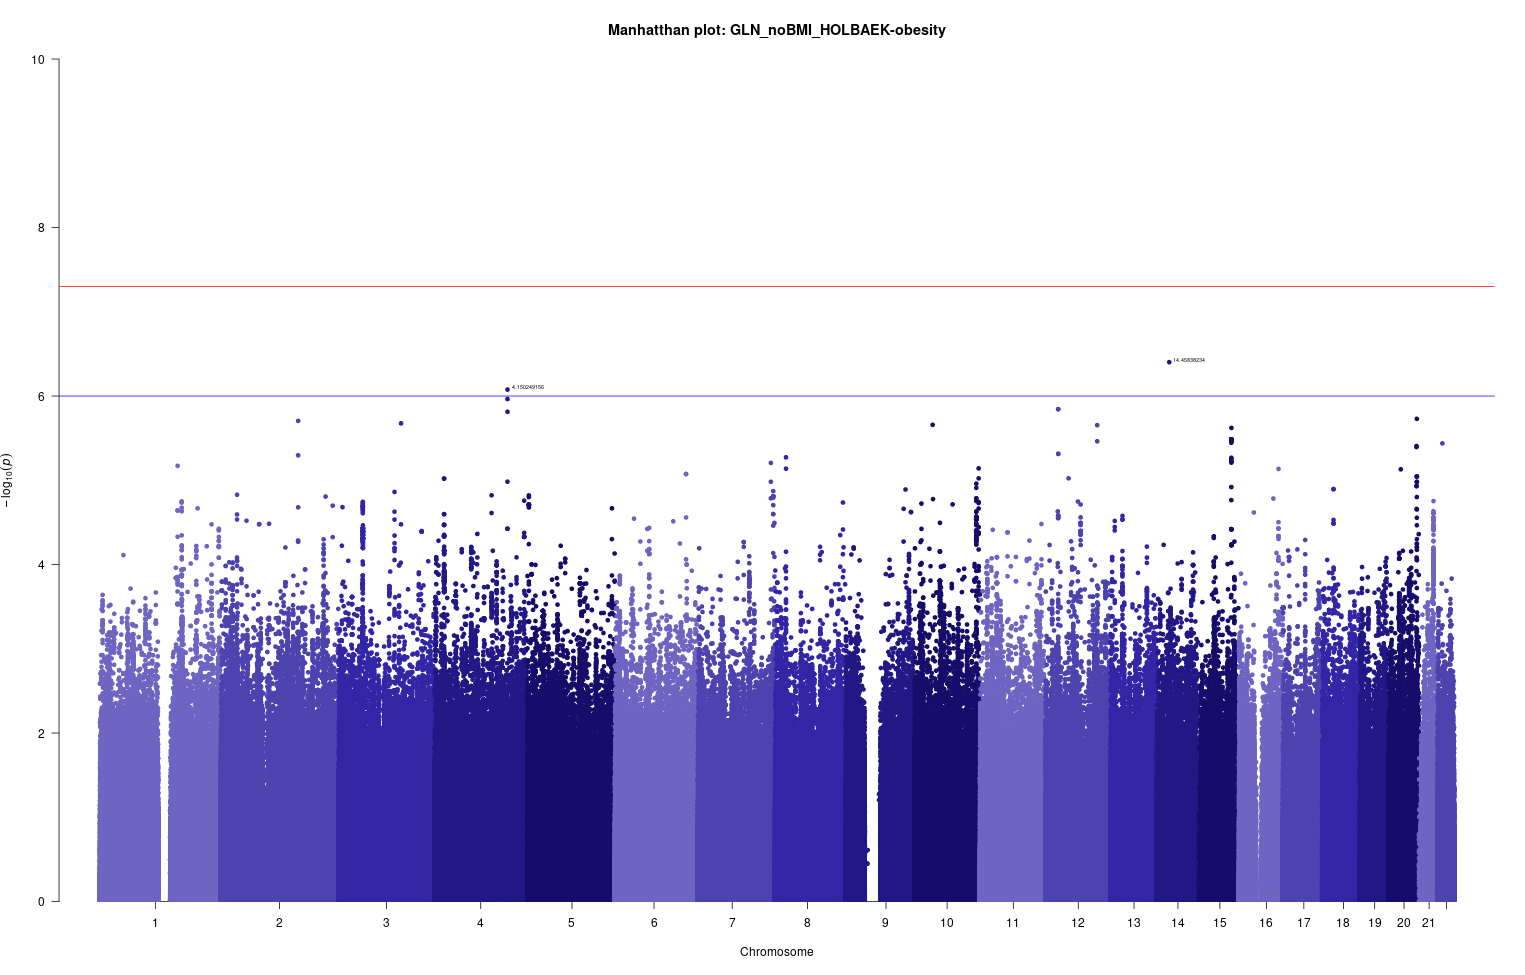

In [36]:
from IPython.display import Image
Image(filename='manhattan_GLN_noBMI_HOLBAEK-obesity.png') 

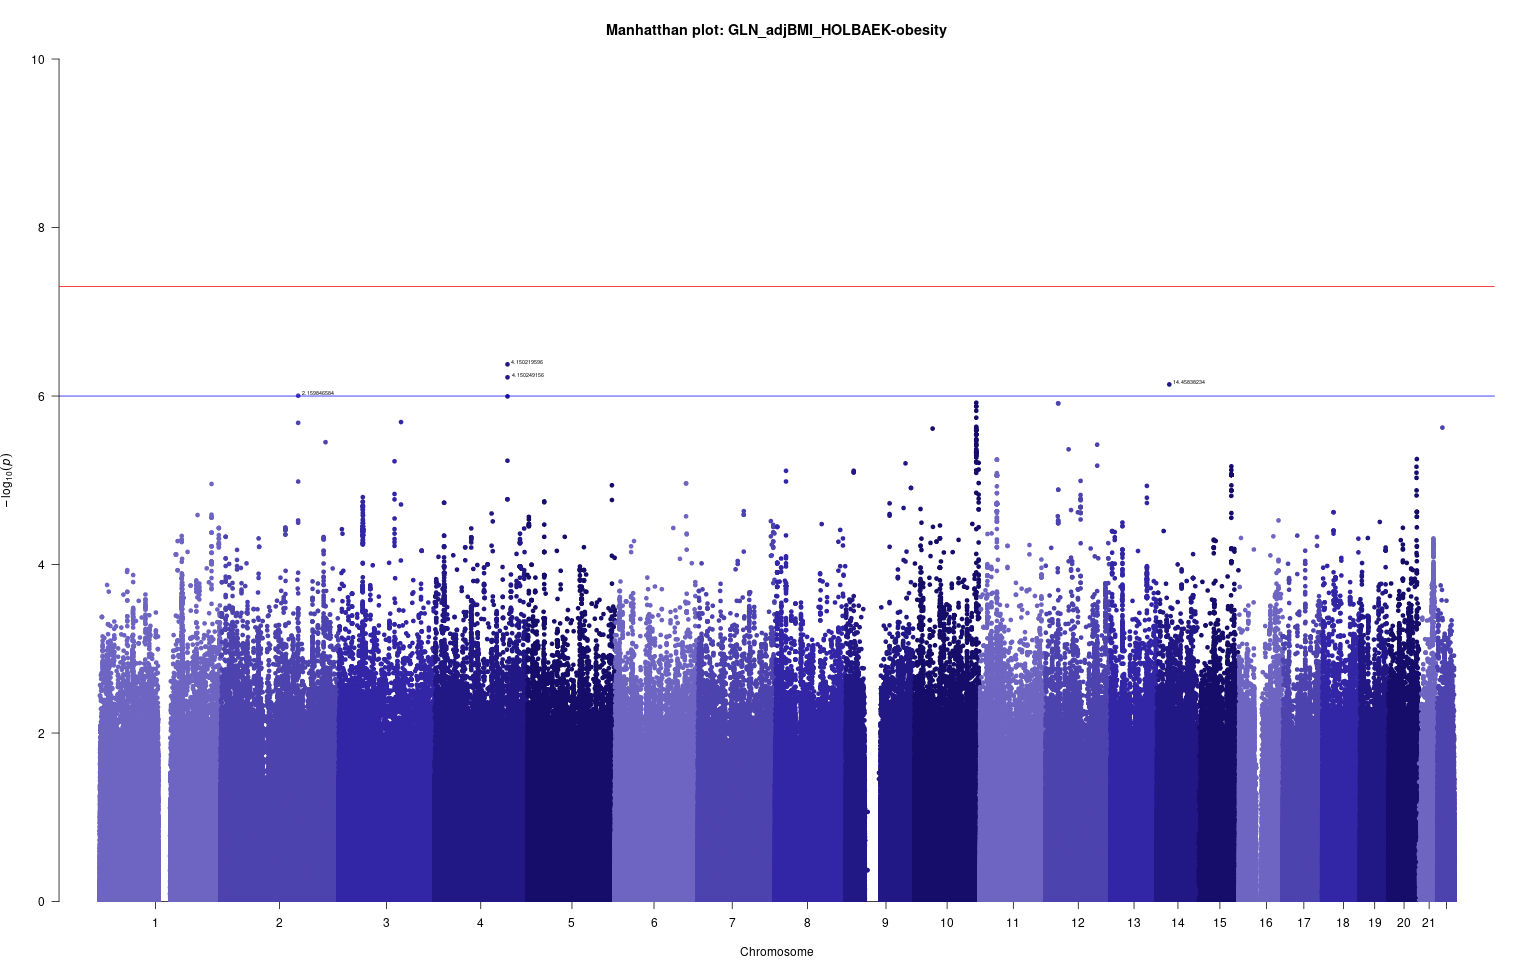

In [37]:
from IPython.display import Image
Image(filename='manhattan_GLN_adjBMI_HOLBAEK-obesity.png') 

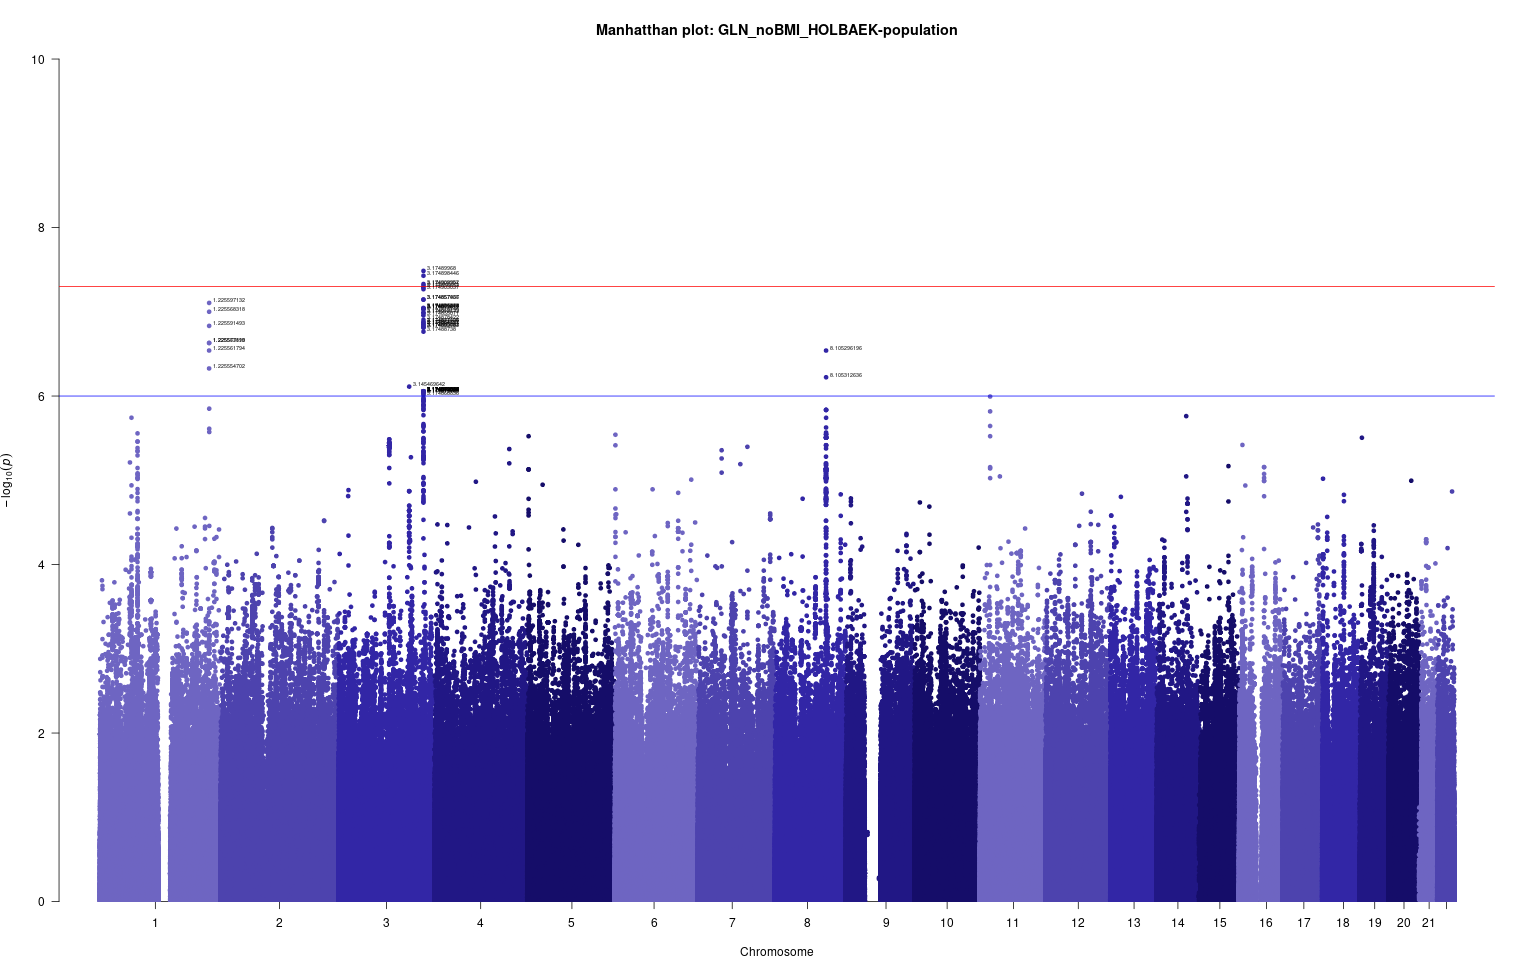

In [40]:
from IPython.display import Image
Image(filename='manhattan_GLN_noBMI_HOLBAEK-population.png') 

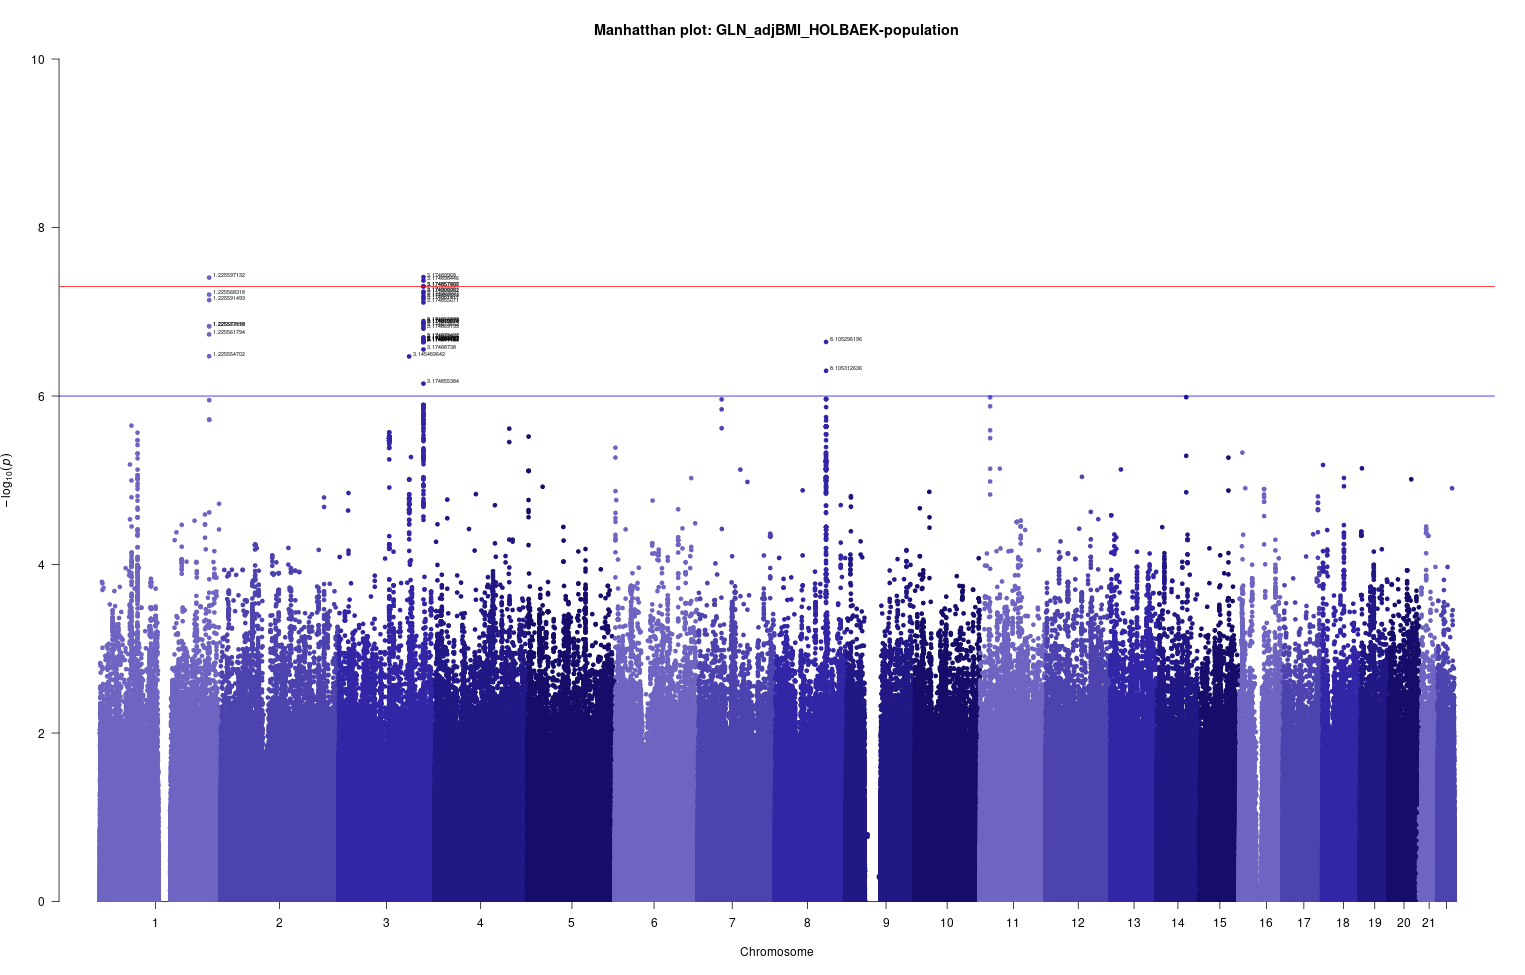

In [43]:
from IPython.display import Image
Image(filename='manhattan_GLN_adjBMI_HOLBAEK-population.png') 

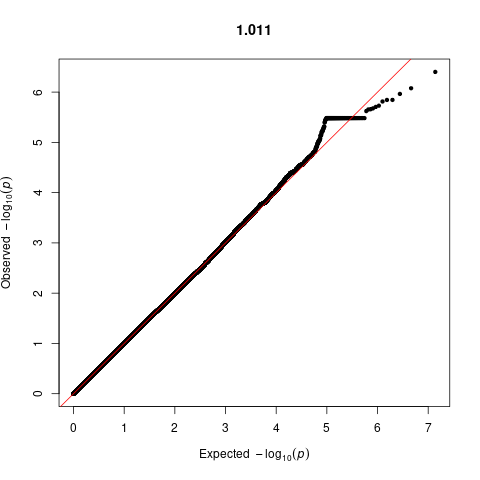

In [39]:
from IPython.display import Image
Image(filename='qq-plot_GLN_noBMI_HOLBAEK-obesity.png') 

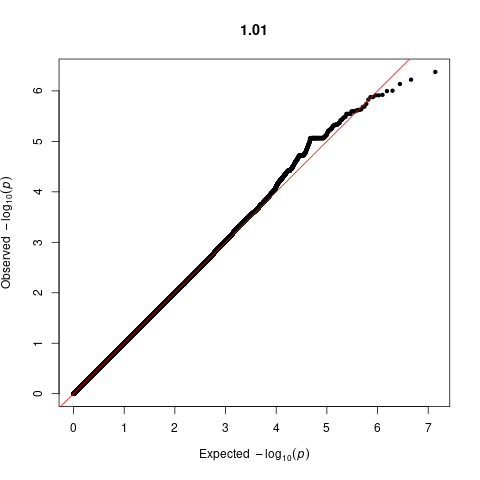

In [38]:
from IPython.display import Image
Image(filename='qq-plot_GLN_adjBMI_HOLBAEK-obesity.png') 

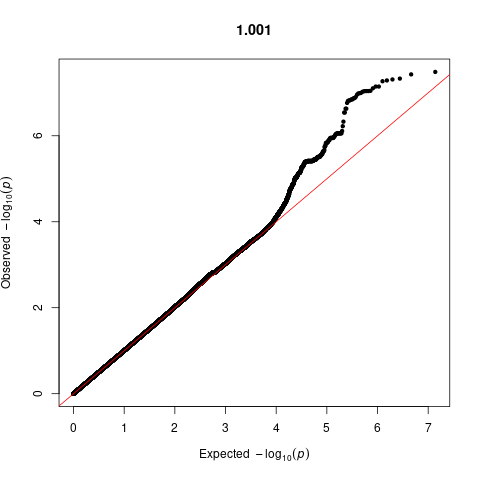

In [41]:
from IPython.display import Image
Image(filename='qq-plot_GLN_noBMI_HOLBAEK-population.png') 

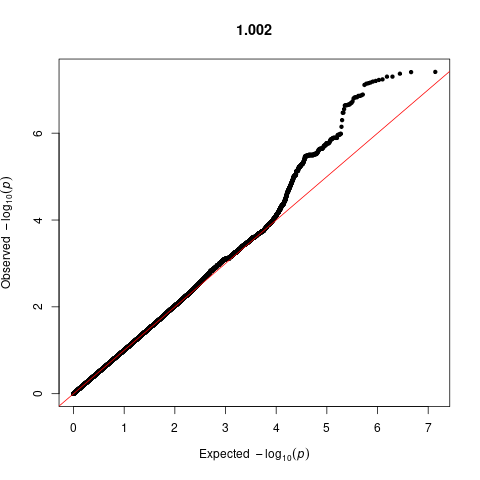

In [42]:
from IPython.display import Image
Image(filename='qq-plot_GLN_adjBMI_HOLBAEK-population.png') 